In [1]:
%run -i 'test_helper_func.py'

....<scipy.stats.kde.gaussian_kde object at 0x7fd159d33c90>
.........
----------------------------------------------------------------------
Ran 13 tests in 2.104s

OK


# Moosejaw grain elevator project
+ carbonation calibration
+ cracking prediction

In [10]:
# load modules
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd

from helper_func import *
from carbonation import Carbonation_Model
from chloride import Chloride_Model



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input data

In [11]:
# weather data
wetdays = [] # 2009-2019 average
for year in np.arange(2009,2020,1):
    df = pd.read_csv('weather/en_climate_daily_SK_4016699_{}_P1D.csv'.format(year))
    wetdays.append(len(df[df['Total Precip (mm)']>2.5])/len(df))
    
RHs = [] # 2019 average
month_str = ['0'+str(item)  for item in np.arange(1,13,1) if len(str(item))==1]
for month in month_str:
    df = pd.read_csv('weather/en_climate_hourly_SK_4016699_{}-2019_P1H.csv'.format(month))
    RHs.append(df['Rel Hum (%)'].mean())
    

In [12]:
# field carbonation data
df_carbon = pd.read_excel('field data/carbonation_updated_complete_cover.xlsx',
              sheet_name='Carbonation Modified', skiprows=3,
             nrows=13, usecols=('B:H'))
# external carbonation depth
carbon_depth_ex = df_carbon.iloc[0:8].set_index('Sample').to_numpy().flatten()

# internal carbonation depth
wall_thickness = 177.8 # mm  7 inch
bar_size = 12.7 # mm  1/2 inch
carbon_depth_in = wall_thickness - df_carbon.iloc[8:13].set_index('Sample').to_numpy().flatten()

# external cover
    # cover on horizontal rebar
cover_mean_h = 44.7
cover_std_h = 11.2

    # cover on vertical rebar
cover_mean_v = 111.5
cover_std_v = 34.1

# internal cover
    # cover on horizontal rebar
cover_mean_h_in = wall_thickness-bar_size-cover_mean_h
cover_std_h_in = 11.2

    # cover on vertical rebar
cover_mean_v_in = wall_thickness-bar_size-cover_mean_v
cover_std_v_in = 34.1

# project test data
year_start = 1913
age = 2019 - year_start


In [13]:
print('external carbonation depth',carbon_depth_ex.mean(), '\ncover_h', 
      cover_mean_h,'\ncover_v', cover_mean_v)

print('\ninternal carbonation depth',carbon_depth_in.mean(), '\ncover_h', 
      cover_mean_h_in, '\ncover_v',cover_mean_v_in)


external carbonation depth 31.083333333333332 
cover_h 44.7 
cover_v 111.5

internal carbonation depth 115.2666666666667 
cover_h 120.40000000000002 
cover_v 53.60000000000002


# Carbonation

In [14]:
# raw parameter, for external condition
class Wrapper: pass
raw_pars = Wrapper()

raw_pars.RH_real = np.array(RHs).mean()
raw_pars.t_c = 28 # vitural lab test curing date
raw_pars.x_c = 0.008  # m initial guess of material property
raw_pars.ToW = np.array(wetdays).mean() #     raw_pars.ToW : time of wetness [-]
                   #     ToW = (days with rainfall h_Nd >= 2.5 mm per day)/365
raw_pars.p_SR = 1.0    # exposed vertial wall, probability of driving rain = 1, assumed
raw_pars.C_S_emi = 0.  ## account for extra CO2 emission

In [15]:
# Carbonation model - external condition (default)
model_carb = Carbonation_Model(raw_pars)
# calibrate for external carbonation
model_carb = model_carb.calibrate(age,carb_depth_field=carbon_depth_ex,print_out=True)

# Carbonation model - internal condition
model_carb_in = model_carb.copy()
model_carb_in.pars.p_SR = 0.0  # internal
model_carb_in.pars.RH_real = 0.5 * (np.array(RHs).mean() + 50)
# calibrate for internal carbonation
model_carb_in = model_carb_in.calibrate(age,carb_depth_field=carbon_depth_in,print_out=True)


carb_depth:
model: 
mean:31.090029492487364
std:15.042117445810485
field: 
mean:31.083333333333332
std:18.94821158374115
carb_depth:
model: 
mean:115.22878926622961
std:22.501842396645877
field: 
mean:115.2666666666667
std:13.363964814214215


## Horizontal rebar cover

+ **external**

Pf(g = R-S < 0) from various methods
    sample count: 0.22883263150524621
    g integral: 0.22936683763355867
    R S integral: 0.22837102512225574
    beta_factor: 0.7256235020212822


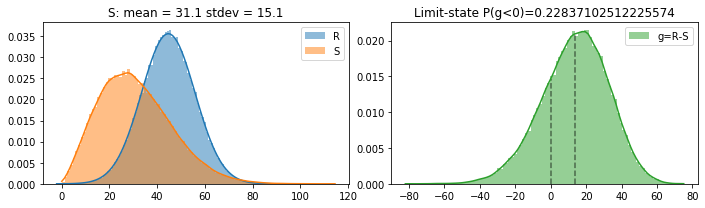

<Figure size 432x288 with 0 Axes>

In [16]:
# horizontal bar cover - external 
model_carb_h = model_carb.copy()
model_carb_h.pars.cover_mean = cover_mean_h  # mm
model_carb_h.pars.cover_std = cover_std_h # mm


model_carb_h.run(age)
model_carb_h.postproc(plot=True)
plt.tight_layout()
# plt.savefig('plots/carbonation_external_horizontal_2019.pdf',dpi=600)
# plt.savefig('plots/carbonation_external_horizontal_2019_example30years.pdf',dpi=600)

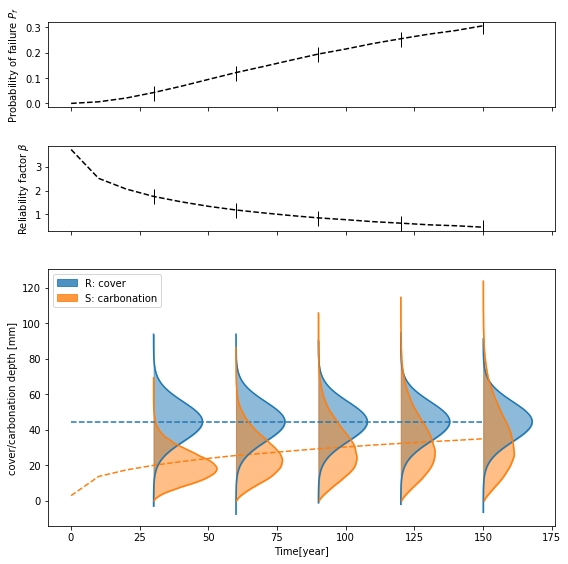

In [17]:
service_life_inspect = np.arange(0.1,150+1,10)
pf_lis_h, beta_lis_h = model_carb_h.carb_with_year(year_lis=service_life_inspect ,plot=True, amplify=500)

In [147]:
# plt.savefig('plots/carbonation at horizontal rebar (low cover) for 150 years since Year 1913.pdf',dpi=600)

+ **internal**

/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:254: RuntimeWarning: divide by zero encountered in power
  W = (t_0 / t) ** ((p_SR * ToW) ** b_w / 2.0)
/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:63: RuntimeWarning: invalid value encountered in sqrt
  pars.k = (2 * pars.k_e * pars.k_c * (pars.k_t * pars.R_ACC_0_inv + pars.eps_t) * pars.C_S) ** 0.5 * pars.W_t


Pf(g = R-S < 0) from various methods
    sample count: 0.42002620288231707
    g integral: 0.41964627435589
    R S integral: 0.4196167256031768
    beta_factor: 0.20493836162888826


<IPython.core.display.Javascript object>


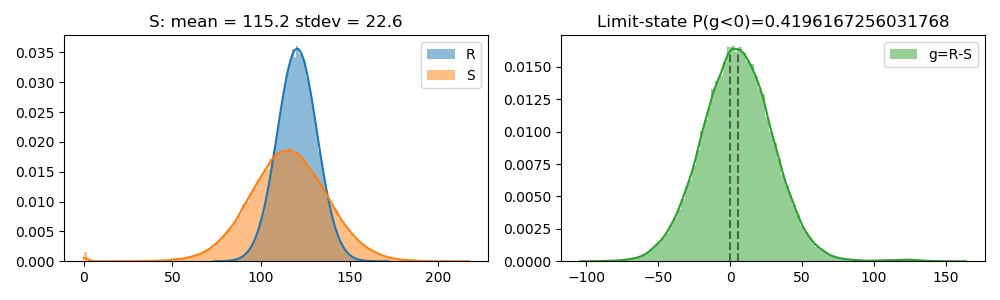

In [16]:
# horizontal bar cover - internal 
model_carb_h_in = model_carb_in.copy()
model_carb_h_in.pars.cover_mean = cover_mean_h_in  # mm
model_carb_h_in.pars.cover_std = cover_std_h_in # mm


model_carb_h_in.run(age)
model_carb_h_in.postproc(plot=True)
plt.tight_layout()
# plt.savefig('plots/carbonation_internal_horizontal_2019.pdf',dpi=600)

/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:254: RuntimeWarning: divide by zero encountered in power
  W = (t_0 / t) ** ((p_SR * ToW) ** b_w / 2.0)
/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:63: RuntimeWarning: invalid value encountered in sqrt
  pars.k = (2 * pars.k_e * pars.k_c * (pars.k_t * pars.R_ACC_0_inv + pars.eps_t) * pars.C_S) ** 0.5 * pars.W_t


<IPython.core.display.Javascript object>


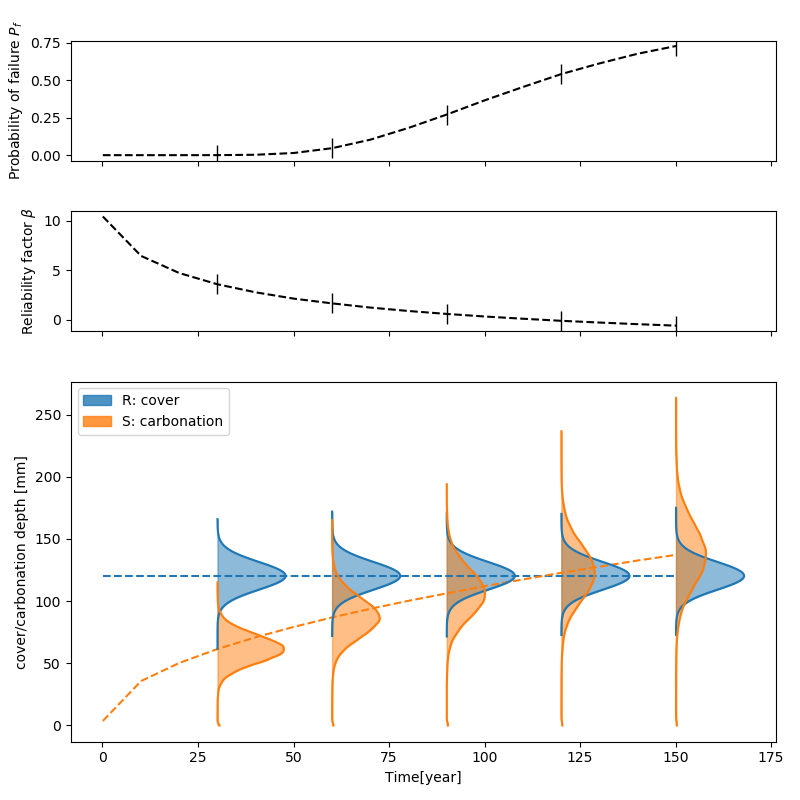

In [17]:
service_life_inspect = np.arange(0.1,150+1,10)
pf_lis_h_in, beta_lis_h_in = model_carb_h_in.carb_with_year(year_lis=service_life_inspect ,plot=True, amplify=500)

In [78]:
# plt.savefig('plots/carbonation at horizontal rebar (low cover) for 150 years since Year 1913_internal.pdf',dpi=600)

## Vertical rebar cover

+ **external**

/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:63: RuntimeWarning: invalid value encountered in sqrt
  pars.k = (2 * pars.k_e * pars.k_c * (pars.k_t * pars.R_ACC_0_inv + pars.eps_t) * pars.C_S) ** 0.5 * pars.W_t


Pf(g = R-S < 0) from various methods
    sample count: 0.016061927431291756
    g integral: 0.016375407090348428
    R S integral: 0.0163947826869058
    beta_factor: 2.163598327699814


<IPython.core.display.Javascript object>


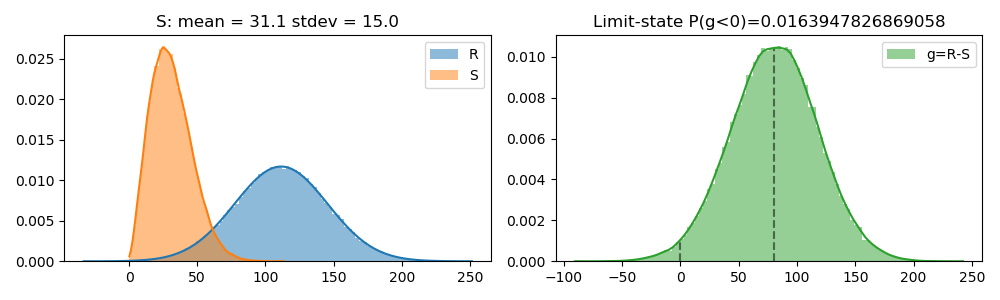

In [21]:
# vertical bar cover [high cover] - external 
model_carb_v = model_carb.copy()
model_carb_v.pars.cover_mean = cover_mean_v  # mm
model_carb_v.pars.cover_std = cover_std_v # mm


model_carb_v.run(age)
model_carb_v.postproc(plot=True)
plt.tight_layout()
# plt.savefig('plots/carbonation_external_vertical_2019.pdf',dpi=600)

/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:63: RuntimeWarning: invalid value encountered in sqrt
  pars.k = (2 * pars.k_e * pars.k_c * (pars.k_t * pars.R_ACC_0_inv + pars.eps_t) * pars.C_S) ** 0.5 * pars.W_t


<IPython.core.display.Javascript object>


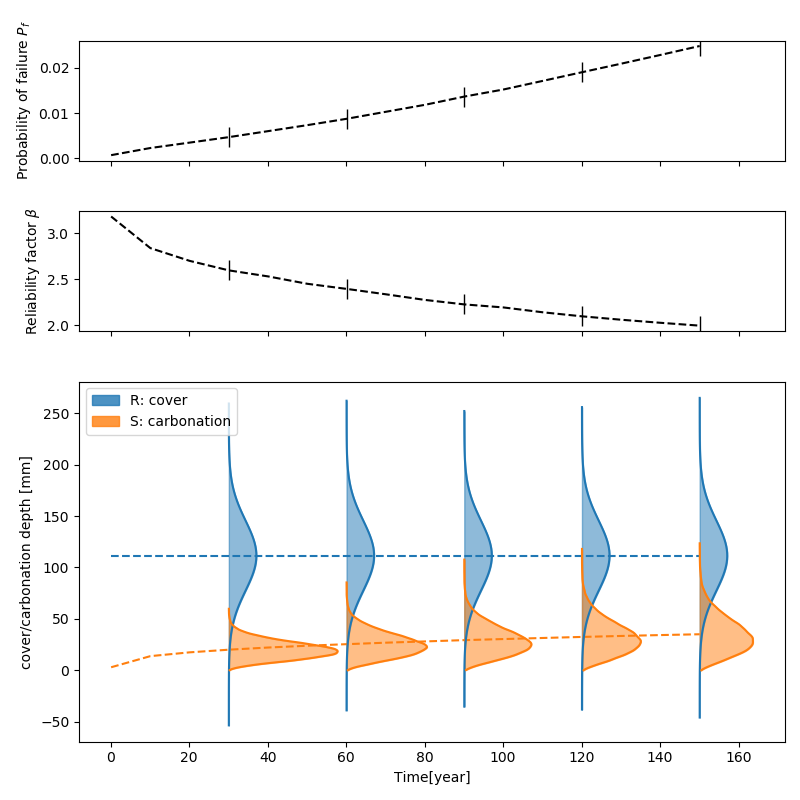

In [23]:
service_life_inspect = np.arange(0.1,150+1,10)
pf_lis_v, beta_lis_v = model_carb_v.carb_with_year(year_lis=service_life_inspect ,plot=True, amplify=600)

In [24]:
# plt.savefig('plots/carbonation at vertical rebar (high cover) for 150 years since Year 1913.pdf',dpi=600)

+ **internal**

/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:254: RuntimeWarning: divide by zero encountered in power
  W = (t_0 / t) ** ((p_SR * ToW) ** b_w / 2.0)
/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:63: RuntimeWarning: invalid value encountered in sqrt
  pars.k = (2 * pars.k_e * pars.k_c * (pars.k_t * pars.R_ACC_0_inv + pars.eps_t) * pars.C_S) ** 0.5 * pars.W_t


Pf(g = R-S < 0) from various methods
    sample count: 0.9352502875431314
    g integral: 0.934370940885993
    R S integral: 0.9345080255290532
    beta_factor: -1.5091087359464892


<IPython.core.display.Javascript object>


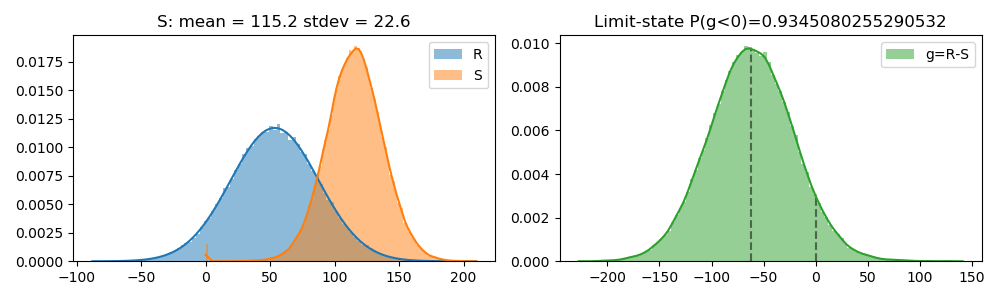

In [25]:
# vertical bar cover - internal 
model_carb_v_in = model_carb_in.copy()
model_carb_v_in.pars.cover_mean = cover_mean_v_in  # mm
model_carb_v_in.pars.cover_std = cover_std_v_in # mm


model_carb_v_in.run(age)
model_carb_v_in.postproc(plot=True)
plt.tight_layout()
# plt.savefig('plots/carbonation_internal_vertical_2019.pdf',dpi=600)

In [26]:
service_life_inspect = np.arange(0.1,150+1,10)
pf_lis_v_in, beta_lis_v_in = model_carb_v_in.carb_with_year(year_lis=service_life_inspect ,plot=True, amplify=600)

/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:254: RuntimeWarning: divide by zero encountered in power
  W = (t_0 / t) ** ((p_SR * ToW) ** b_w / 2.0)
/Users/gangli/Local Documents/Mitacs project local/Tinkrete_beta 0.1_for silo project/carbonation.py:63: RuntimeWarning: invalid value encountered in sqrt
  pars.k = (2 * pars.k_e * pars.k_c * (pars.k_t * pars.R_ACC_0_inv + pars.eps_t) * pars.C_S) ** 0.5 * pars.W_t


<IPython.core.display.Javascript object>

In [27]:
# plt.savefig('plots/carbonation at vertical rebar (high cover) for 150 years since Year 1913_internal.pdf',dpi=600)

## carbonation compare plot

<IPython.core.display.Javascript object>


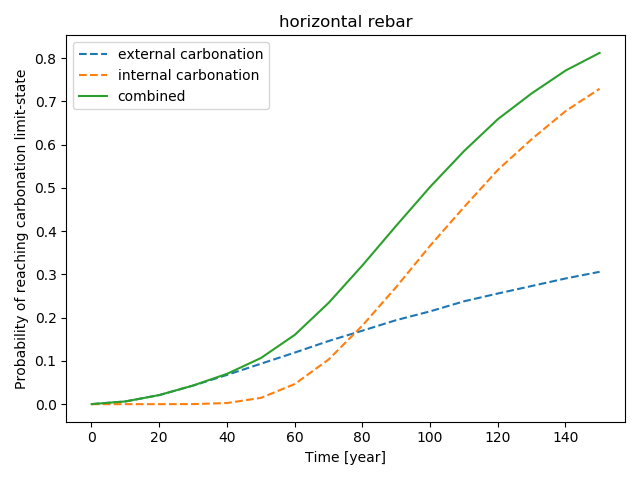

In [28]:
fig, ax = plt.subplots()
ax.plot(service_life_inspect, pf_lis_h,'--', label = 'external carbonation')
ax.plot(service_life_inspect, pf_lis_h_in,'--', label = 'internal carbonation')
pf_lis_h_combine = 1-(1-pf_lis_h)*(1-pf_lis_h_in)  # at least one: 1- P(none)

ax.plot(service_life_inspect, pf_lis_h_combine, label = 'combined')
ax.set_title('horizontal rebar')
ax.set_xlabel('Time [year]')
ax.set_ylabel('Probability of reaching carbonation limit-state')
ax.legend()
plt.tight_layout()
# fig.savefig('plots/p_carbonation horizontal rebar.pdf', dpi=600)

<IPython.core.display.Javascript object>


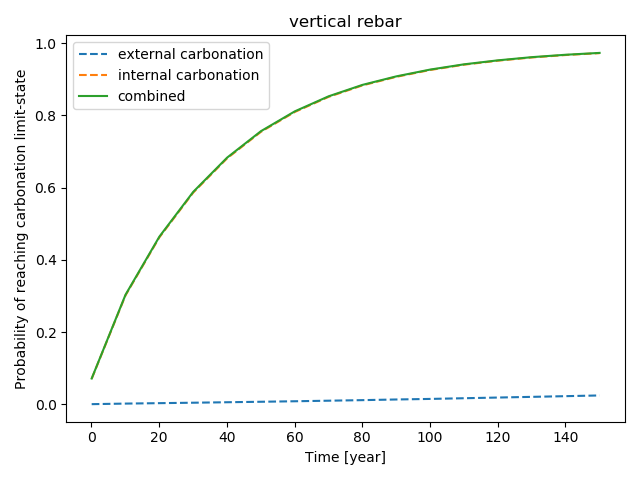

In [29]:
fig, ax = plt.subplots()
ax.plot(service_life_inspect, pf_lis_v,'--', label = 'external carbonation')
ax.plot(service_life_inspect, pf_lis_v_in,'--', label = 'internal carbonation')
pf_lis_v_combine = 1-(1-pf_lis_v)*(1-pf_lis_v_in)  # at least one: 1- P(none)

ax.plot(service_life_inspect, pf_lis_v_combine, label = 'combined')
ax.set_title('vertical rebar')
ax.set_xlabel('Time [year]')
ax.set_ylabel('Probability of reaching carbonation limit-state')
ax.legend()
plt.tight_layout()
# fig.savefig('plots/p_carbonation vertical rebar.pdf', dpi=600)

# corrosion

In [30]:
# corrosion - from previous report
r_corr_mean = 2.0e-6 #  m/year average
r_corr_std = 0.062e-6


def PsiFun(RH,T):                       # convert RH, T to Psi, Young-Laplace and Kelvin
    Mh2o = 18.01528e-3                  # kg/mol, molar mass of water
    rhoh2o = 1000                       # kg/m3, density of water
    Vmh2o = Mh2o/rhoh2o                 # m3/mol, molar volume of water
    g=9.8                               # m/s^2, gravitational acceleration
    R = 8.3144598                       # J/(K*mol), ideal gas constant
    Psi= np.log(RH)*(R*T)/Vmh2o/(rhoh2o*g)
    return Psi

psi = PsiFun(model_carb_in.pars.RH_real/100, 273.15+20)
# according to the water retention curve, 
n =1.7
alpha = 0.0018 # 1/m
m= 1-1/n
Se = (1+ np.abs(alpha*psi)**n)**(-m)
theta_water = 0.19 *Se # porosity 0.19
print('volumetric water content', theta_water)

r_corr_mean_in = theta_water/((0.053+0.056+0.052)/3) *r_corr_mean
print('internal corrosion rate',r_corr_mean_in)

volumetric water content 0.029893803262782858
internal corrosion rate 1.1140547799794852e-06


# cracking - corrosion-induced 
+ assumption: no other stresses
+ step 1: time to surface crack for both rebar covers(h rebar: external cover  v rebar: internal cover )
+ step 2: combine with the preobability of corrosion onset

In [31]:
from cracking import Cracking_Model

print('external carbonation depth',carbon_depth_ex.mean(), '\ncover_h', 
      cover_mean_h,'\ncover_v', cover_mean_v)

print('\ninternal carbonation depth',carbon_depth_in.mean(), '\ncover_h', 
      wall_thickness - cover_mean_h, '\ncover_v',wall_thickness - cover_mean_v)



external carbonation depth 31.083333333333332 
cover_h 44.7 
cover_v 111.5

internal carbonation depth 115.2666666666667 
cover_h 133.10000000000002 
cover_v 66.30000000000001


## horizontal rebar - external cover

In [32]:
# cracking - horizontal external cover[low cover]

class Param: pass
cr_pars = Param()

r0_bar_mean = 12.7e-3 # m 1/2 inch
f_c = 20
rho_c= 2300
f_t_mean= f_c*0.1 # MPa
E_0_mean=(3300*f_c**0.5 + 6900)*(rho_c/2300)**1.5  # ACI Committee 363 f 21<fc<83 MPa Design code CSA A23.3-04

cr_pars.cover = Normal_custom(cover_mean_h * 1e-3, 
                cover_std_h * 1e-3, non_negative=True) # m horizontal rebar cover

# assumed
cr_pars.f_t = Normal_custom(f_t_mean, 0.2*f_t_mean, non_negative=True)
cr_pars.E_0 = Normal_custom(E_0_mean, 0.2*E_0_mean, non_negative=True)

cr_pars.r0_bar = Normal_custom(r0_bar_mean, 0.1*r0_bar_mean, non_negative=True)
cr_pars.w_c = Normal_custom(0.8, 0.1*0.8, non_negative=True)

# initalize 0 section loss
cr_pars.x_loss = Normal_custom(r_corr_mean*0.1, 1e-16, non_negative=True)

# initalize model
model_crack = Cracking_Model(cr_pars)



In [119]:
# surface crack vs time [NOTE: 10 min runtime]
model_crack_lis = []

from tqdm import tqdm # add progress bar
_years = np.arange(0.5,20,0.5)
for _year in tqdm(_years):
    
    model_crack.pars.x_loss = Normal_custom(r_corr_mean *_year , r_corr_std*_year, non_negative=True)
    
    model_crack.run(stochastic=True)
    model_crack.postproc()
    model_crack_lis.append(model_crack.copy())
    


100%|██████████| 39/39 [17:12<00:00, 26.48s/it]


<IPython.core.display.Javascript object>


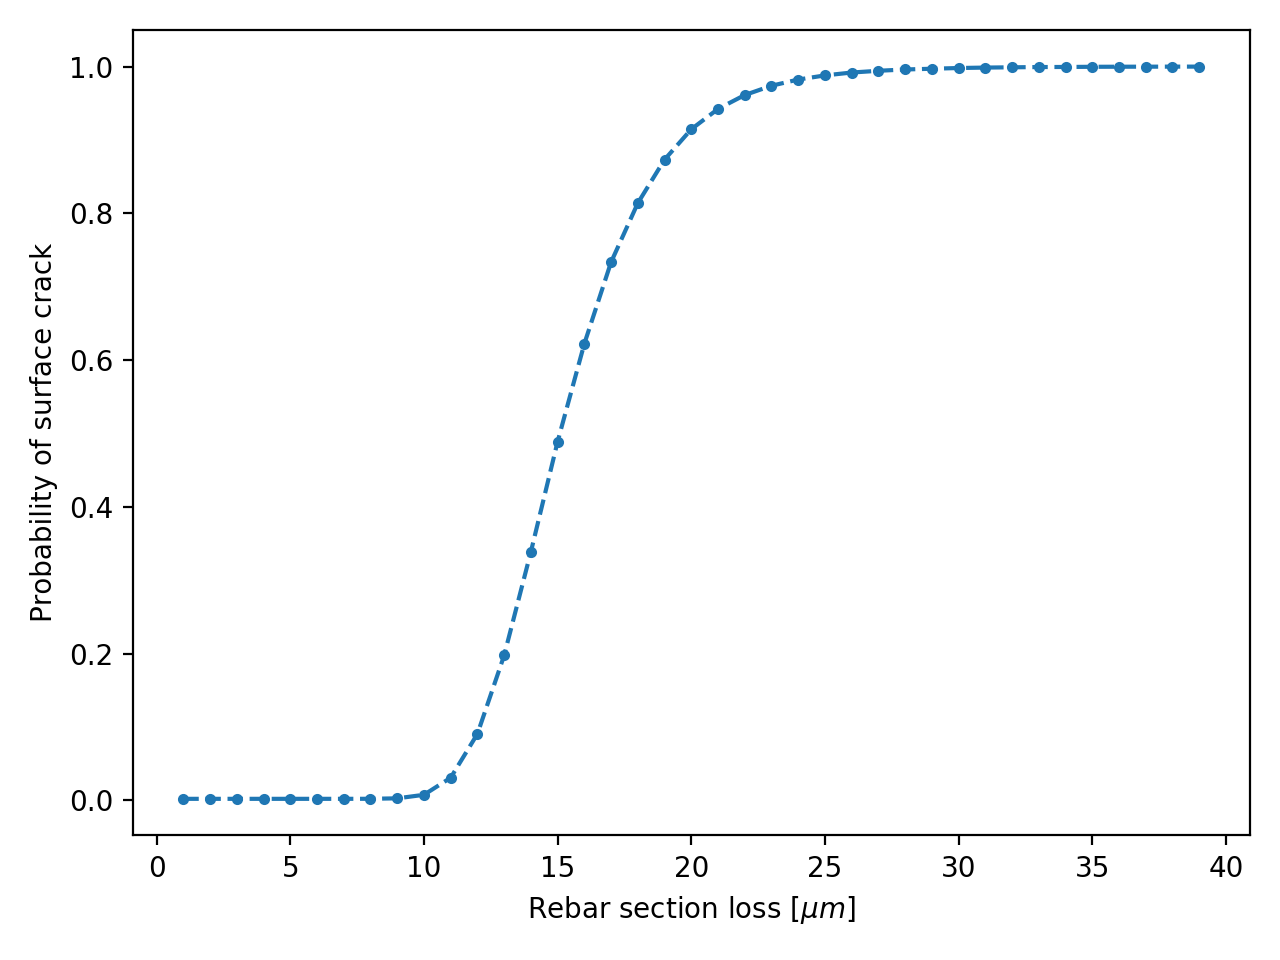

In [120]:
fig,ax=plt.subplots()
x_loss_array = _years*r_corr_mean
p_surface_crack_array = np.array([m.crack_visible_rate_count for m in model_crack_lis])
ax.plot(x_loss_array*1e6,p_surface_crack_array, '--.')
ax.set_xlabel('Rebar section loss $[\mu m]$')
ax.set_ylabel('Probability of surface crack')
plt.tight_layout()

# save to disk
# plt.savefig('plots/Corrosion-induced surface crack for horizontal rebar (low cover).pdf',dpi=600)
# pd.DataFrame({'section loss[m]':x_loss_array, 'probability of surface crack':p_surface_crack_array}).to_csv("tables/section loss and surface cracking.csv", index=None)

## vertical rebar -internal cover

In [33]:
# cracking - vertical internal cover [low cover]
# create model from horizontal model_crack
model_crack_v = model_crack.copy()

model_crack_v.pars.cover = Normal_custom(cover_mean_v_in * 1e-3, 
                cover_std_v_in * 1e-3, non_negative=True) # m horizontal rebar cover



In [88]:
# surface crack vs time [NOTE: 20 min runtime]
model_crack_lis_v = []

from tqdm import tqdm # add progress bar
_years = np.arange(0.5,40,0.5)
for _year in tqdm(_years):
    
    model_crack_v.pars.x_loss = Normal_custom(r_corr_mean *_year , r_corr_std*_year, non_negative=True)
    
    model_crack_v.run(stochastic=True)
    model_crack_v.postproc()
    model_crack_lis_v.append(model_crack_v.copy())
    



100%|██████████| 79/79 [2:39:45<00:00, 121.34s/it]  


<IPython.core.display.Javascript object>


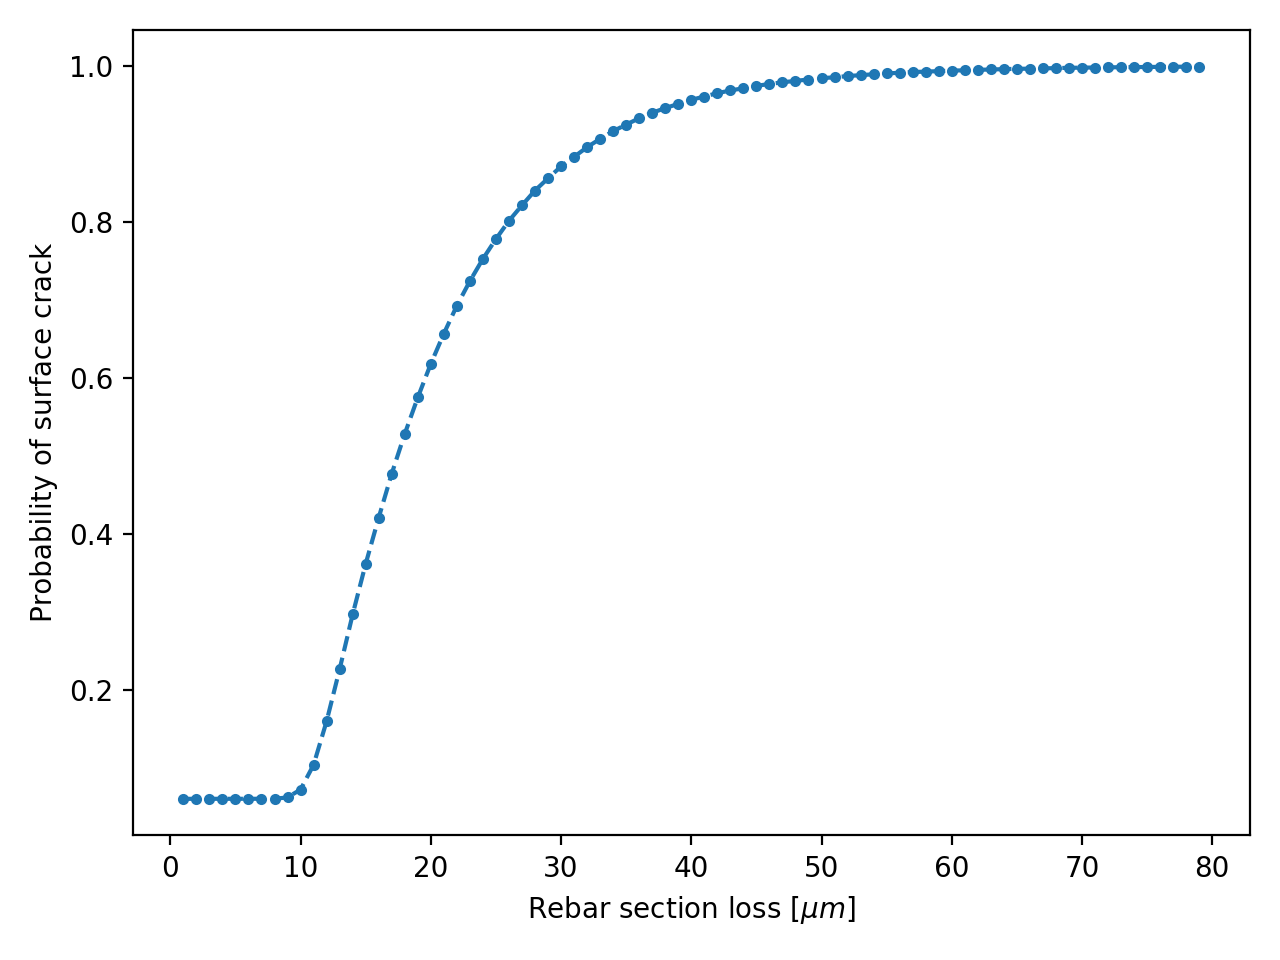

In [106]:
fig,ax=plt.subplots()
x_loss_array_v = _years*r_corr_mean
p_surface_crack_array_v = np.array([m.crack_visible_rate_count for m in model_crack_lis_v])
ax.plot(x_loss_array*1e6,p_surface_crack_array_v, '--.')
ax.set_xlabel('Rebar section loss $[\mu m]$')
ax.set_ylabel('Probability of surface crack')
plt.tight_layout()

# save to disk
# plt.savefig('plots/Corrosion-induced surface crack for vertical rebar (low cover internal).pdf',dpi=600)
# pd.DataFrame({'section loss[m]':x_loss_array, 'probability of surface crack':p_surface_crack_array_v}).to_csv("tables/section loss and surface cracking_vertical bar internal cover.csv", index=None)

# [combined] probability of surface crack at time t

In [163]:
# p_crack_t = f(p_carbonation_t, p_surface crack_x_loss)
def p_crack_t_fun(t, r_corr_mean,p_carbonation_t_curve, p_surface_crack_x_loss_curve):
    """interpolation curves p_carbonation_t_curve = (service_life_inspect, pf_lis), 
    p_surface_crack_x_loss_curve = (x_loss_array, p_surface_crack_array)"""
    p_crack_t=[]
    service_life_inspect, pf_lis_h = p_carbonation_t_curve
    x_loss_array, p_surface_crack_array = p_surface_crack_x_loss_curve
    
    for ti in t:
        # inspection in this_year
        t_lis = t[0 : np.where(t == ti)[0][0]+1 ]
        age_lis = ti - t
        age_lis = age_lis[age_lis>=0]
        x_loss_lis = age_lis * r_corr_mean

        # interpolate to x_loss-p_surface crack curve
        p_crack_xloss_lis = np.interp(x_loss_lis,x_loss_array, p_surface_crack_array)

        # interpolate to time-p_onset
        pf_lis = np.interp(t_lis,service_life_inspect, pf_lis_h)

        p_corr_onset_lis =  np.diff(pf_lis,prepend=0)
        p_crack_t.append(np.sum(p_crack_xloss_lis * p_corr_onset_lis))
    return np.array(p_crack_t)
    



<IPython.core.display.Javascript object>


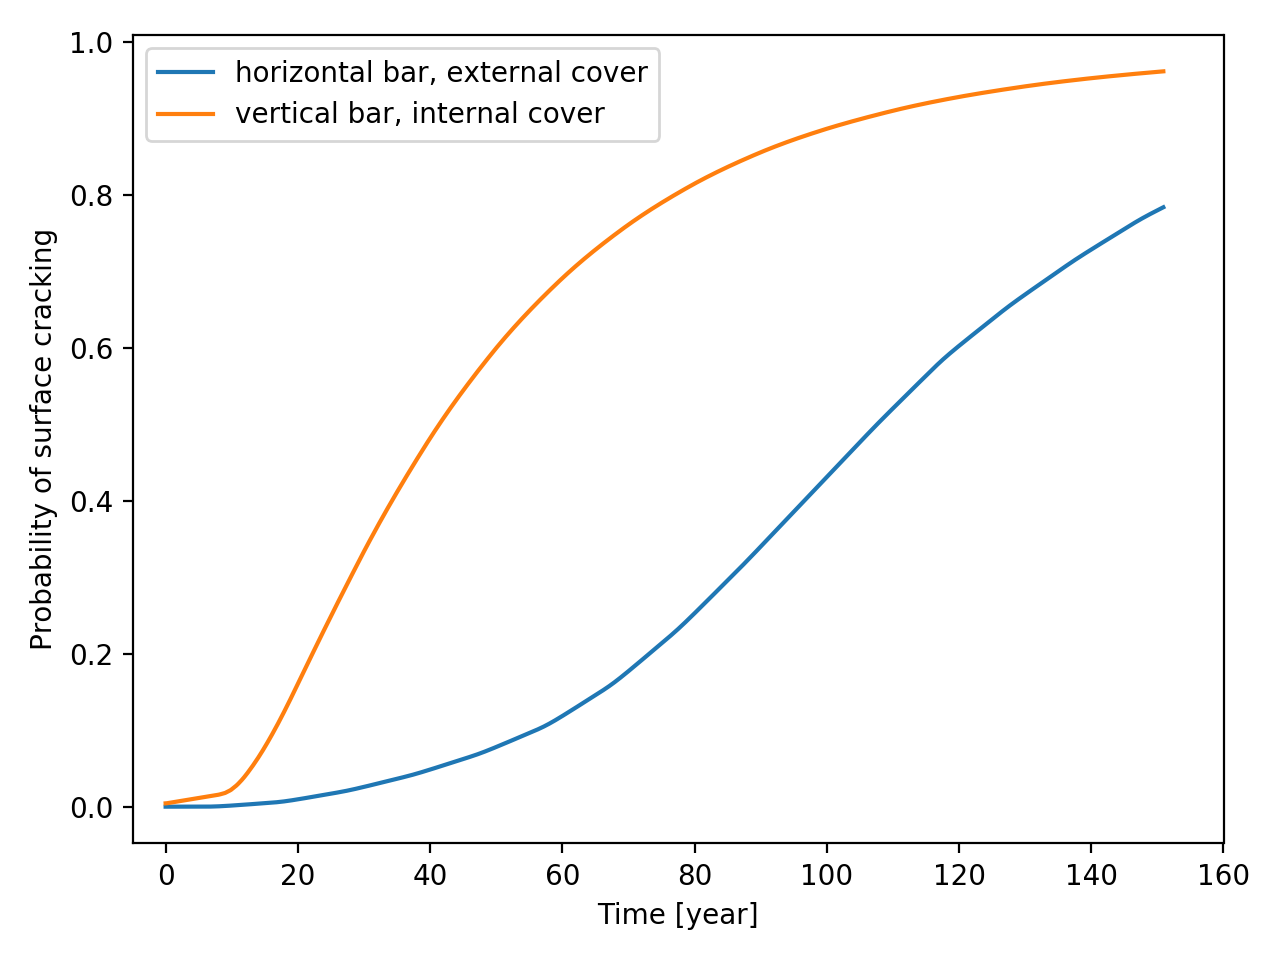

In [194]:
t = np.arange(0,151,0.1)

# horizontal bar external surface
p_crack_t = p_crack_t_fun(t,
                          r_corr_mean,
                          p_carbonation_t_curve=(service_life_inspect, pf_lis_h_combine), 
                          p_surface_crack_x_loss_curve= (x_loss_array, p_surface_crack_array))

# vertical bar internal surface
p_crack_t_v = p_crack_t_fun(t, 
                         r_corr_mean_in,
                          p_carbonation_t_curve=(service_life_inspect, pf_lis_v_combine), 
                          p_surface_crack_x_loss_curve= (x_loss_array_v, p_surface_crack_array_v))



fig,ax = plt.subplots()
ax.plot(t, p_crack_t,'-', label='horizontal bar, external cover')
ax.plot(t, p_crack_t_v,'-',label='vertical bar, internal cover')
ax.set_xlim(-5,160)
ax.set_xlabel('Time [year]')
ax.set_ylabel('Probability of surface cracking')
plt.tight_layout()
plt.legend()
# fig.savefig('plots/p_surface crack vs year.pdf', dpi=600)



# section loss of 0.5 mm

In [34]:
# output section loss distribution at time t
# p_crack_t = f(p_carbonation_t, p_surface crack_x_loss)
def x_loss_t_fun(t_end, n_step, r_corr_mean, p_carbonation_t_curve):
    """return x_loss samples at a SINGLE given time t. the samples represents distribution of all possible x_loss with different history
    interpolation curves p_carbonation_t_curve = (service_life_inspect, pf_lis)"""

    service_life_inspect, pf_lis_h = p_carbonation_t_curve
    t = np.linspace(0,t_end, n_step)
    # inspection in this_year
    age_lis = t_end - t
    age_lis = age_lis[age_lis>=0]
    x_loss_lis = age_lis * r_corr_mean

    # interpolate to time-p_onset
    pf_lis = np.interp(t,service_life_inspect, pf_lis_h)

    p_corr_onset_lis =  np.diff(pf_lis,prepend=0)

    from random import choices
    x_loss_at_t = choices(x_loss_lis , p_corr_onset_lis, k = N_SAMPLE)
        
    return np.array(x_loss_at_t)
    

In [51]:
def x_loss_year(model, year_lis, plot=True, amplify=80):
    """run function over time"""
    t_lis = year_lis
    M_cal = model

    M_lis = []
    for t in t_lis:
        M_cal.run(t)
        M_cal.postproc()
        M_lis.append(M_cal.copy())

    if plot:
        fig,[ax1,ax2,ax3] = plt.subplots(nrows = 3, figsize=(8,8),sharex=True,gridspec_kw={'height_ratios': [1,1,3]})
        # plot a few distrubtion
        indx = np.linspace(0,len(year_lis)-1,min(6,len(year_lis))).astype('int')[1:]
        M_sel = [M_lis[i] for i in indx]

        ax1.plot([this_M.t for this_M in M_lis], [this_M.pf for this_M in M_lis],'k--')
        ax1.plot([this_M.t for this_M in M_sel], [this_M.pf for this_M in M_sel],'k|', markersize=15)
        ax1.set_ylabel('Probability of failure $P_f$')

        ax2.plot([this_M.t for this_M in M_lis], [this_M.beta_factor for this_M in M_lis], 'k--')
        ax2.plot([this_M.t for this_M in M_sel], [this_M.beta_factor for this_M in M_sel], 'k|', markersize=15)
        ax2.set_ylabel(r'Reliability factor $\beta$')

        # plot mean results
        ax3.plot(t_lis, [M.pars.x_loss_limit_mean for M in M_lis], '--C0')
        ax3.plot(t_lis, [Get_mean(M.x_loss_t) for M in M_lis], '--C1')
        # plot distribution
        
        for this_M in M_sel:
            RS_plot(this_M, ax=ax3, t_offset=this_M.t, amplify=amplify)

        import matplotlib.patches as mpatches
        R_patch = mpatches.Patch(color='C0', label='R: limit',alpha=0.8)
        S_patch = mpatches.Patch(color='C1', label='S: section loss',alpha=0.8)

        ax3.set_xlabel('Time[year]')
        ax3.set_ylabel('section loss/limit [mm]')
        ax3.legend(handles=[R_patch, S_patch],loc='upper left')

        plt.tight_layout()

    return [this_M.pf for this_M in M_lis], [this_M.beta_factor for this_M in M_lis]

In [52]:
class Section_loss:
    def __init__(self, pars):
        self.pars = pars  # pars with user-input

    def run(self, t_end):
        """t[year]"""
        self.t = t_end
        self.x_loss_t = x_loss_t_fun(t_end, N_SAMPLE, self.pars.r_corr_mean, self.pars.p_carbonation_t_curve)

    def postproc(self, plot=False):
        sol = Pf_RS((self.pars.x_loss_limit_mean, self.pars.x_loss_limit_std), self.x_loss_t, plot=plot)
        self.pf = sol[0]
        self.beta_factor = sol[1]
        self.R_distrib = sol[2]
        self.S_kde_fit = sol[3]
        self.S = self.x_loss_t
    
    def copy(self):
        from copy import deepcopy
        return deepcopy(self)
    
    def section_loss_with_year(self, year_lis, plot=True, amplify=1):
        pf_lis, beta_lis = x_loss_year(self, year_lis, plot=plot, amplify=amplify)
        return np.array(pf_lis), np.array(beta_lis)


In [61]:
# horizontal rebar section loss [mm]
s_pars = Param()
s_pars.r_corr_mean = r_corr_mean*1e3   # mm/year 
s_pars.p_carbonation_t_curve = (service_life_inspect, pf_lis_h_combine)
s_pars.x_loss_limit_mean = 0.5 # mm
s_pars.x_loss_limit_std = 0.5 * 0.1 # mm



<IPython.core.display.Javascript object>


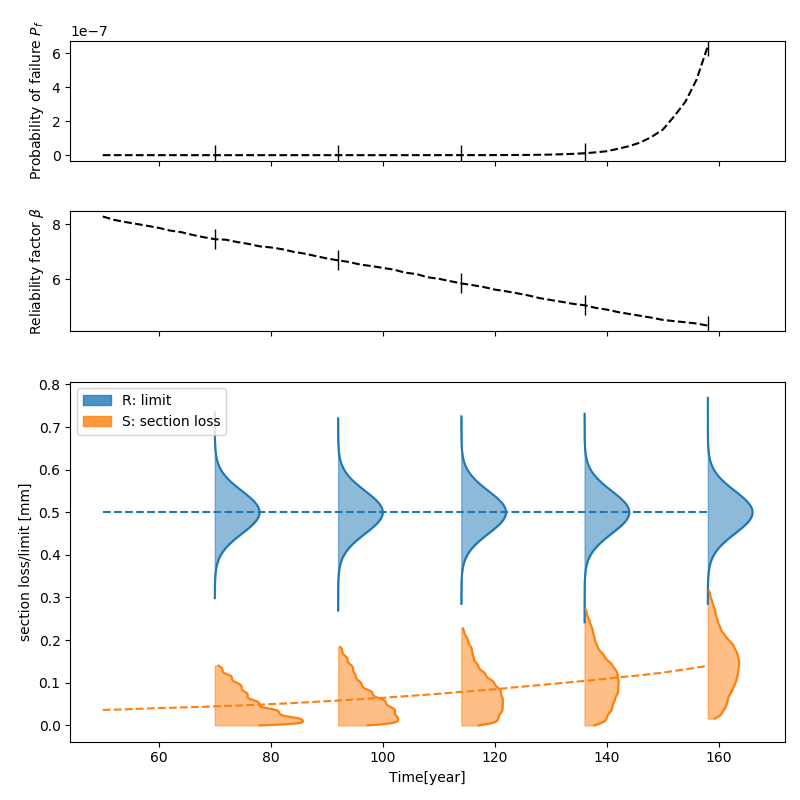

In [66]:
model_sl = Section_loss(s_pars)
# model_sl.run(150)
# model_sl.postproc(plot=True)
pf_sl, beta_sl = model_sl.section_loss_with_year(year_lis=np.arange(50,160,2), amplify=1)

In [67]:
# plt.savefig('plots/section loss with year horizontal rebar.pdf',dpi=600)

<IPython.core.display.Javascript object>


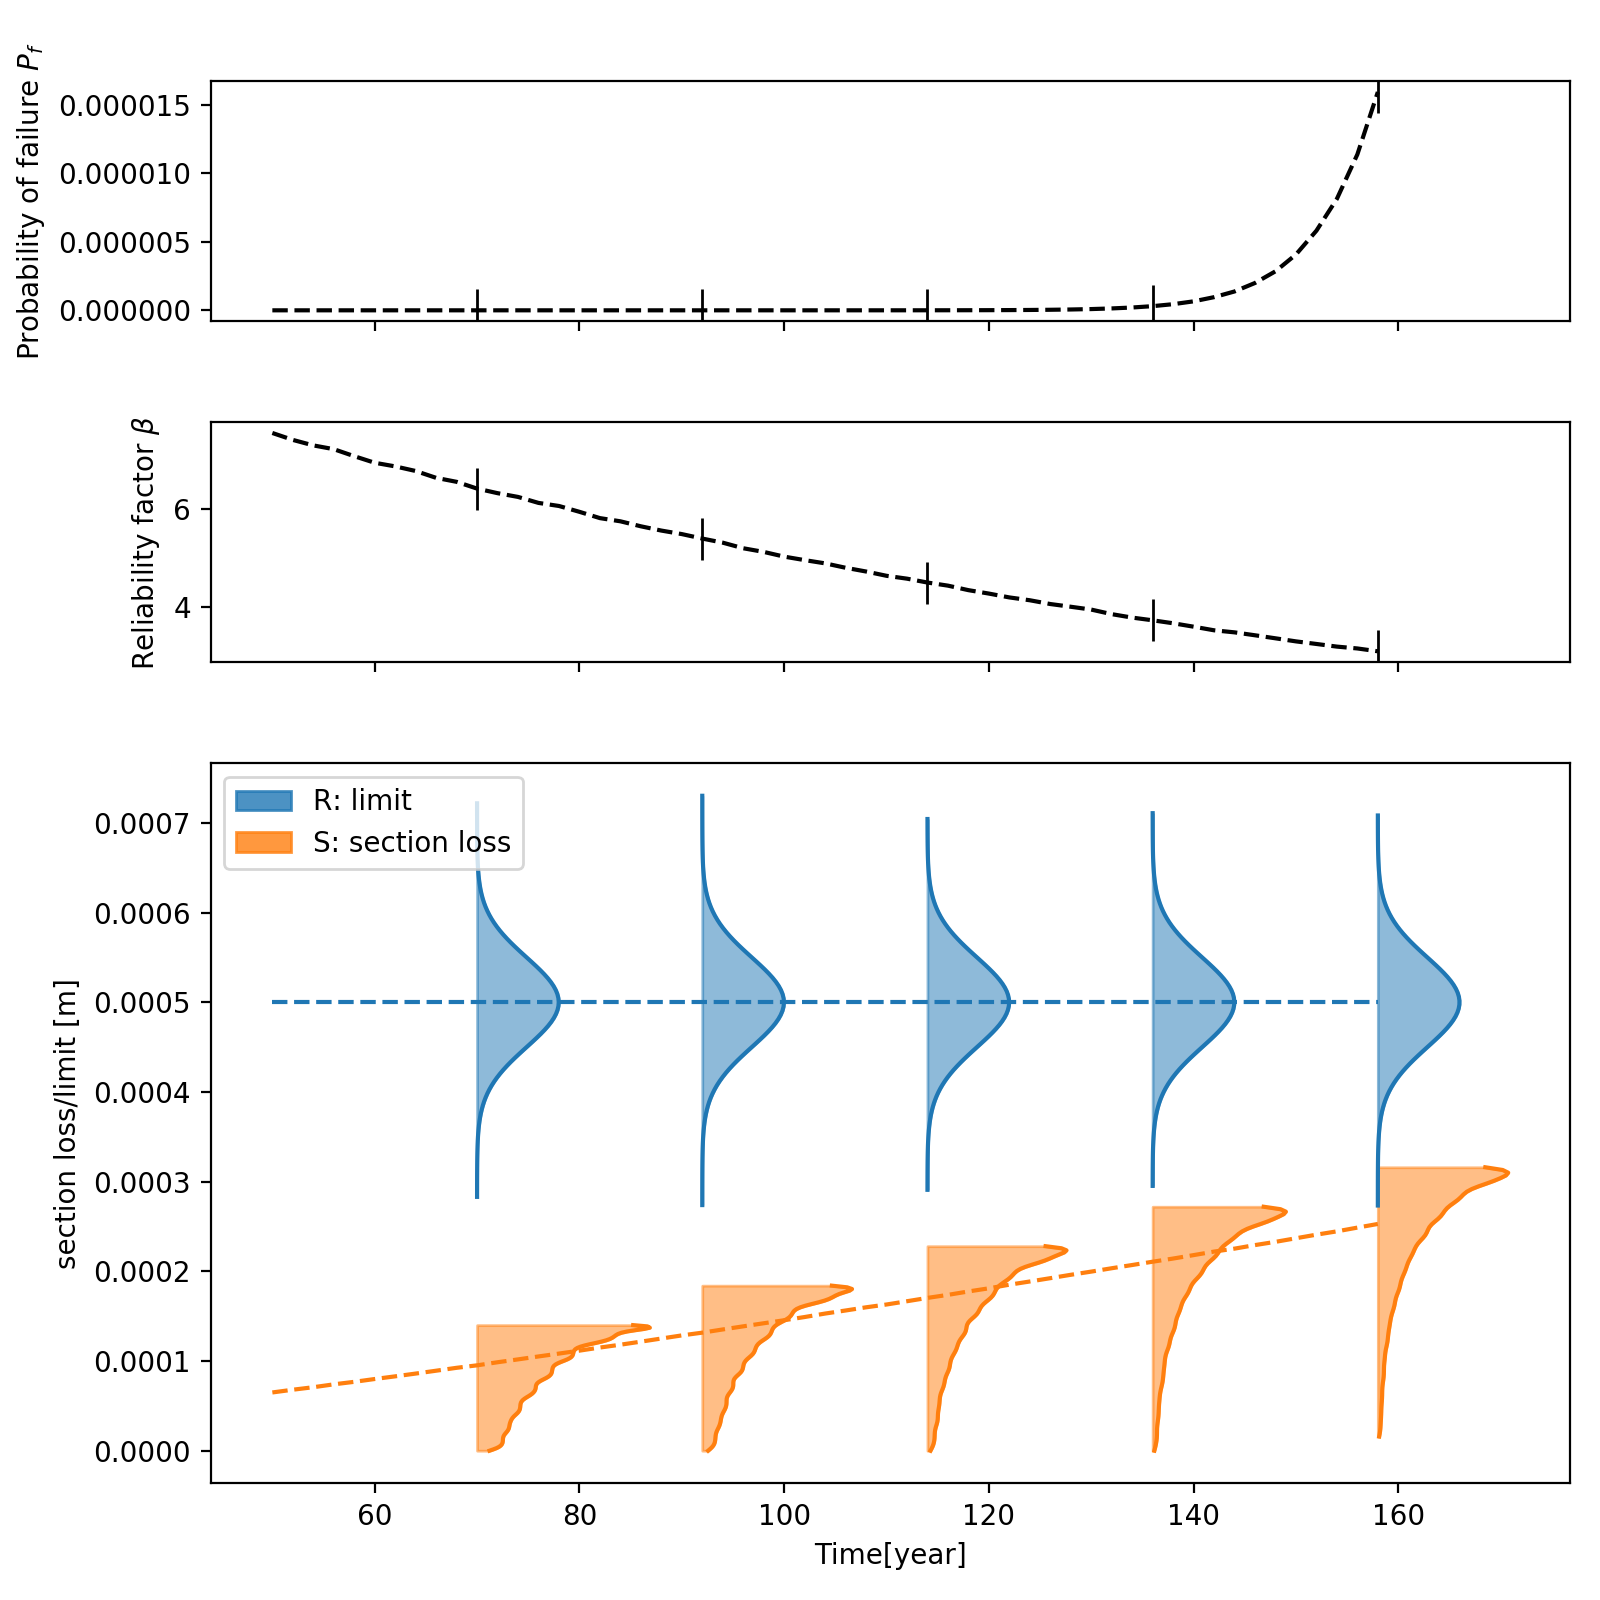

70
92
114
136
158


In [330]:
# vertical rebar section loss
model_sl_v = model_sl.copy()
model_sl_v.pars.r_corr_mean = r_corr_mean*1e3  # mm/year
model_sl_v.pars.p_carbonation_t_curve = (service_life_inspect, pf_lis_v_combine)
model_sl = Section_loss(s_pars)
pf_sl, beta_sl = model_sl_v.section_loss_with_year(year_lis=np.arange(50,160,2))


In [335]:
# plt.savefig('plots/section loss with year vertical rebar.pdf',dpi=600)